In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

'''
STDP modulated with reward

Adapted from Fig. 1c of:
Eugene M. Izhikevich 
Solving the distal reward problem through linkage of STDP and dopamine signaling. 
Cerebral cortex 17, no. 10 (2007): 2443-2452.

Note:
The variable "mode" can switch the behavior of the synapse from "Classical STDP" to "Dopamine modulated STDP".

Author: Guillaume Dumas (Institut Pasteur)
Date: 2018-08-24
'''
from brian2 import *

# Parameters
simulation_duration = 100* second

## Neurons
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

## STDP
taupre = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax

## Dopamine signaling
tauc = 1000*ms
taud = 200*ms
taus = 1*ms
epsilon_dopa = 5e-3

# Setting the stage
network = Network()

## Stimuli section
num_neurons = 100

input_rate = 1*Hz
input = PoissonGroup(num_neurons, input_rate)
network.add(input)

neurons = NeuronGroup(num_neurons, '''dv/dt = (ge * (Ee-vr) + El - v) / taum : volt
                                      dge/dt = -ge / taue : 1''',
                      threshold='v>vt', reset='v = vr',
                      method='linear')
neurons.v = vr
network.add(neurons)

neurons_monitor = SpikeMonitor(neurons, ['v'], record=True)
network.add(neurons_monitor)

synapse = Synapses(input, neurons, 
                   model='''s: volt''',
                   on_pre='v += s')
synapse.connect(i=list(range(0, num_neurons)), j=list(range(0, num_neurons)))
synapse.s = 100. * mV

network.add(synapse)

## STDP section
epsilon = 0.1 # sparseness of synaptic connections

synapse_stdp = Synapses(neurons, neurons,
                   model='''mode: 1
                         dc/dt = -c / tauc : 1 (clock-driven)
                         dd/dt = -d / taud : 1 (clock-driven)
                         ds/dt = mode * c * d / taus : 1 (clock-driven)
                         dApre/dt = -Apre / taupre : 1 (event-driven)
                         dApost/dt = -Apost / taupost : 1 (event-driven)''',
                   on_pre='''ge += s
                          Apre += dApre
                          c = clip(c + mode * Apost, -gmax, gmax)
                          s = clip(s + (1-mode) * Apost, -gmax, gmax)
                          ''',
                   on_post='''Apost += dApost
                          c = clip(c + mode * Apre, -gmax, gmax)
                          s = clip(s + (1-mode) * Apre, -gmax, gmax)
                          ''',
                   method='euler'
                   )
synapse_stdp.connect(p=epsilon, condition='i!=j')
if not((0, 1) in zip(synapse_stdp.i, synapse_stdp.j)):
    synapse_stdp.connect(i=0, j=1)

k = 0
for i, j in zip(synapse_stdp.i, synapse_stdp.j):
    if ((i,j)==(0,1)):
        break
    k+=1

synapse_stdp.mode = 0
synapse_stdp.s = 1e-10
synapse_stdp.c = 1e-10
synapse_stdp.d = 0

network.add(synapse_stdp)

synapse_stdp_monitor = StateMonitor(synapse_stdp, ['s', 'c', 'd'], record=[k])
network.add(synapse_stdp_monitor)

## Dopamine signaling section

check_reward = NeuronGroup(1, '''dunlock/dt = (-1*second-unlock*0.001)/(1*second) : second
                                 spike : second''',
                          threshold='spike > 1*ms', reset='spike = 0*second', method='linear')
network.add(check_reward)
reward_monitor = SpikeMonitor(check_reward, ['spike'], record=True)
network.add(reward_monitor)

check_pre = Synapses(neurons, check_reward, model='''''', on_pre='unlock_post = 11*ms', method='exact')
check_post = Synapses(neurons, check_reward, model='''''', on_pre='spike_post = clip(unlock_post, 0*second, 11*ms)', method='exact')
check_pre.connect(i=0, j=0)
check_post.connect(i=1, j=0)
network.add(check_pre)
network.add(check_post)

dopamine = NeuronGroup(1, '''v : volt''', threshold='v>1*volt', reset='v=0*volt')
network.add(dopamine)
dopamine_trigger = Synapses(check_reward, dopamine, model='''''', on_pre='v_post += 2*volt', method='exact')
dopamine_trigger.connect(p=1.)
network.add(dopamine_trigger)
dopamine_monitor = SpikeMonitor(dopamine)
network.add(dopamine_monitor)


reward = Synapses(dopamine, synapse_stdp, model='''''',
                             on_pre='''d_post += epsilon_dopa''',
                             method='exact')
reward.connect(p=1.)
reward.delay='1*second'
network.add(reward)

# Simulation
## Classical STDP
#synapse_stdp.mode = 0

## Dopamine modulated STDP
synapse_stdp.mode = 1
network.run(simulation_duration, report='text')


WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    c:\users\valentin\appdata\local\programs\python\python37-32\lib\site-packages\sympy\matrices\matrices.py:2479: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()
 [py.warnings]


Starting simulation at t=0. s for a duration of 6. s
4.5419 (75%) simulated in 10s, estimated 3s remaining.
6.0 (100%) simulated in 13s


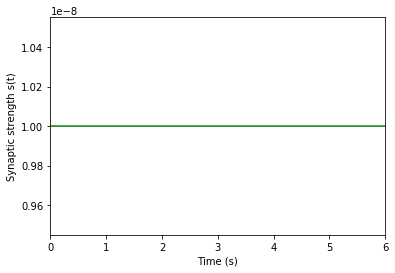

In [3]:
#Visualization :
dopamine_indices, dopamine_times = dopamine_monitor.it
neurons_indices, neurons_times = reward_monitor.it
figure(figsize=(9,9))
subplot(411)
plot([20, simulation_duration/second-20], [2.7, 2.7], linewidth=5, color='k')
text(simulation_duration/second/2, 3, 'Dopamine modulated STDP', horizontalalignment='center', fontsize=20)
plot(neurons_times, neurons_indices, 'ob')
plot(neurons_times, neurons_indices + 1, 'ob')
plot(dopamine_times, dopamine_indices + 2, 'or')
xlim([0, simulation_duration/second])
ylim([-0.5, 4])
yticks([0, 1, 2], ['Pre-neuron', 'Post-neuron', 'Reward'])
xticks([])
subplot(412)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.d.T/gmax, 'r-')
xlim([0, simulation_duration/second])
ylabel('Extracellular dopamine d(t)')
xticks([])
subplot(413)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.c.T/gmax, 'b-')
xlim([0, simulation_duration/second])
ylabel('Eligibility trace c(t)')
xticks([])
subplot(414)
plot(synapse_stdp_monitor.t/second, synapse_stdp_monitor.s.T/gmax, 'g-')
xlim([0, simulation_duration/second])
ylabel('Synaptic strength s(t)')
xlabel('Time (s)')
tight_layout()
show()

In [ ]:
#Visualization 2 :

plt.hist(synapse_stdp.s/gmax)
plt.title("Synaptic weight distribution")
show()